<a href="https://colab.research.google.com/github/MuBai75/MaskRCNN/blob/main/Train%26Evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo fuser /dev/nvidia*

/dev/nvidia0:        66156m
/dev/nvidiactl:      66156m
/dev/nvidia-uvm:     66156m


In [ ]:
!kill -9  66156

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
drive_path="/content/drive/MyDrive/dataset"
os.chdir(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
# from torchvision.datasets import CocoDetection
from MyCoco import MyCocoDetection
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import torchvision
from torch.utils.data import DataLoader
import config
import json
from torchvision.transforms import v2 as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt
import torch
from pycocotools.coco import COCO
import numpy as np
from pycocotools.cocoeval import COCOeval
# from train_utils import train_one_epoch, coco_evaluate
from train_utils import coco_evaluate
from draw_box_utils import draw_objs

In [ ]:
# Define the path to your dataset annotations and images
ann_file = os.path.join(drive_path, 'coco_labels.json')
image_root = os.path.join(drive_path,'images/')
print(image_root)

/content/drive/MyDrive/dataset/images/


In [ ]:
def get_transform(train):
  transforms = []
  transforms.append(T.ToTensor())
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)
def custom_collate_fn(batch):
    images, targets = zip(*batch)
    return images, targets

In [ ]:
import os
file_path = '/content/drive/MyDrive/dataset/MyCoco.py'
exists = os.path.exists(file_path)
print("File exists:", exists)

File exists: True


# Create Dataset

In [ ]:
# Create an instance of your CocoDataset
train_dataset = MyCocoDetection(root=image_root, annFile=ann_file, transform=get_transform(train=True))

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
# print(indices[-100:])
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-100])

# Create a DataLoader with the custom collate function
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=custom_collate_fn
)

indices_to_save = indices[-100:]

with open('saved_indices_model_5.py', 'w') as file:
    file.write('saved_indices = ' + str(indices_to_save))

print("Saved indices to saved_indices.py")


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Saved indices to saved_indices.py


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


# Model

In [ ]:
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights, maskrcnn_resnet50_fpn_v2

def get_model_instance_segmentation(num_classes):
  # load an instance segmentation model pre-trained on COCO
  ''' model = torchvision.models.detection.maskrcnn_resnet50_fpn(
      weights="DEFAULT") '''
  model = maskrcnn_resnet50_fpn_v2(
      weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
      )
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # now get the number of input features for the mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)
  return model


def get_model_instance_segmentation_101(num_classes):
  # load an instance segmentation model pre-trained on COCO
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(
      weights="DEFAULT")
  ''' model = maskrcnn_resnet50_fpn_v2(
      weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
      ) '''
  backbone = torchvision.models.resnet101(pretrained=True, progress=True)

  return model

def get_model_non_pretrained(num_classes):
  # load an instance segmentation model pre-trained on COCO
  model = torchvision.models.detection.maskrcnn_resnet50_fpn()
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # now get the number of input features for the mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)
  return model


In [ ]:
  num_classes = 7
  model = get_model_instance_segmentation(num_classes+1)
  # load an instance segmentation model pre-trained on COCO
  model.to(config.device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [ ]:
num_classes = 7
model = get_model_non_pretrained(num_classes+1)
model.to(config.device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

## Parameter

In [ ]:
# Define the loss function and optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.002, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

In [ ]:
def define_params(model):
  params = [p for p in model.parameters() if p.requires_grad]
  ''' # optimizer = torch.optim.SGD(params, lr=0.002,momentum=0.9, weight_decay=0.0005)
  optimizer = torch.optim.Adam(params, lr=0.008, weight_decay=0.0005)
  # and a learning rate scheduler
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1) '''
  optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
  # and a learning rate scheduler
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)
  return optimizer, lr_scheduler

# Testing

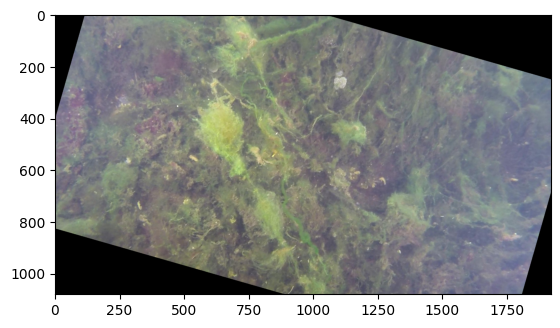

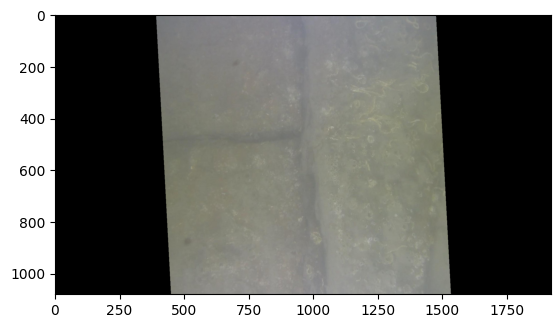

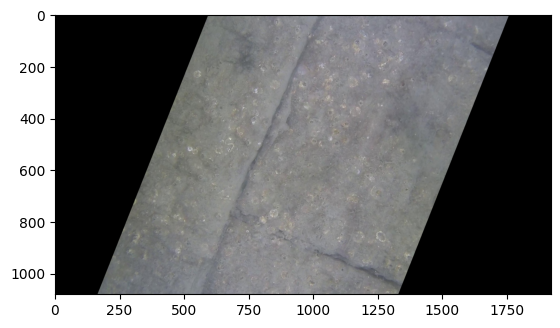

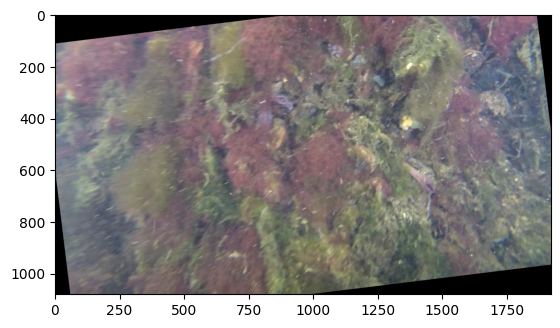

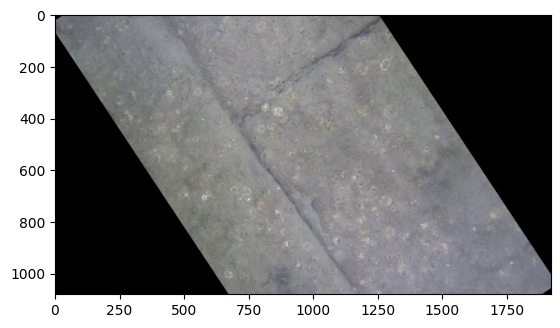

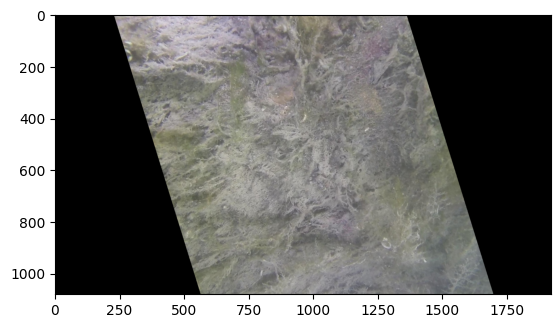

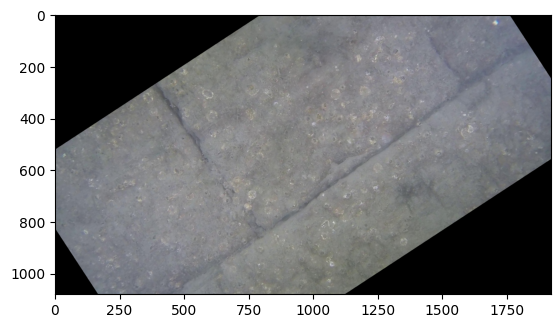

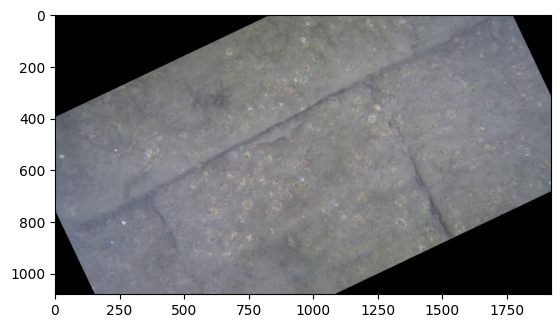

' print(images)\nprint(targets)\noutput = model(images, targets)   # Returns losses and detections\n# For inference\nmodel.eval()\nx = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]\npredictions = model(x)  '

In [ ]:
# For Training
images, targets = next(iter(train_dataloader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

for image in images:
  if image.sum().item() == 0:
    print('图像都是全零')
  image_numpy = image.numpy()

  # Ensure the image has the correct shape
  if image.ndim == 3:
    image_numpy = image_numpy.transpose(1, 2, 0)  # Convert from CxHxW to HxWxC

  # Show the image
  plt.imshow(image_numpy)
  plt.show()
''' total_pixel_sum = sum(image.sum().item() for image in images)

# 如果像素和为零，说明所有图像都是全零
if total_pixel_sum == 0:
    print("所有图像都是全零。")
else:
    print("图像中包含非零像素值。") '''

''' print(images)
print(targets)
output = model(images, targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  '''

# k cross-validation

In [ ]:
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

In [ ]:
# train_dataset = MyCocoDetection(root=image_root, annFile=ann_file, transform=get_transform(train=True))

n_splits=3
# Initialize the KFold cross-validator
kf = KFold(n_splits, shuffle=True, random_state=42)

In [ ]:
# Lists to store evaluation metrics for each fold
fold_metrics = []
# Loop over cross-validation folds
for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{n_splits}")

    # Create subsets for training and testing
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    test_subset = torch.utils.data.Subset(train_dataset, val_index)

    # Create DataLoader for training and testing
    train_subdataloader = DataLoader(
        train_subset,
        batch_size=4,
        shuffle=True,
        num_workers=2,
        collate_fn=custom_collate_fn
    )
    test_subdataloader = DataLoader(
        test_subset,
        batch_size=4,
        shuffle=True,
        num_workers=2,
        collate_fn=custom_collate_fn
    )
    num_classes = 7
    model = get_model_instance_segmentation(num_classes+1)
    model.to(config.device)
    optimizer, lr_scheduler = define_params(model)
    num_epochs = 15  # Adjust the number of training epochs as needed
    for epoch in range(num_epochs):
        # train for one epoch
        epoch_dict = train_one_epoch(model, optimizer, train_subdataloader, config.device, epoch)
        # print(f"Epoch: [{epoch}]")
        # update the learning rate
        lr_scheduler.step()
        print(epoch_dict)


    # Evaluate the model on the test_subset and collect evaluation metrics
    coco_evaluate(model,test_subdataloader,config.device)
    torch.cuda.empty_cache()


Fold 1/3
Epoch: [0]
{'epoch': 0, 'total_loss': 129.34112983942032, 'epoch_loss': 1.361485577257056, 'loss_mask': 0.4115436375141144, 'loss_objectness': 0.020819079130887985, 'loss_box_reg': 0.25543877482414246, 'learning_rate': 0.008000000000000002, 'loss_rpn_box_reg': 0.00531995901837945}
Epoch: [1]
{'epoch': 1, 'total_loss': 78.20718225836754, 'epoch_loss': 0.8232334974565004, 'loss_mask': 0.3893146812915802, 'loss_objectness': 0.06741797178983688, 'loss_box_reg': 0.3024826645851135, 'learning_rate': 0.008000000000000002, 'loss_rpn_box_reg': 0.020295539870858192}
Epoch: [2]
{'epoch': 2, 'total_loss': 63.92073372006416, 'epoch_loss': 0.6728498286322544, 'loss_mask': 0.2628791630268097, 'loss_objectness': 0.017319466918706894, 'loss_box_reg': 0.27796316146850586, 'learning_rate': 0.008000000000000002, 'loss_rpn_box_reg': 0.01076443400233984}
Epoch: [3]
{'epoch': 3, 'total_loss': 50.10080111026764, 'epoch_loss': 0.5273768537922909, 'loss_mask': 0.2568571865558624, 'loss_objectness': 0.0

# Train

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import utils
import math
import sys
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    running_loss = 0.0
    lr_scheduler = None
    # Modify the model for training
    model.train()
    header = f"Epoch: [{epoch}]"
    # scaler = None
    print(header)
    if epoch == 0:
          warmup_factor = 1.0 / 1000
          warmup_iters = min(1000, len(data_loader) - 1)
          lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)

    for images, targets in data_loader:
        if not images:  # Check if the batch is empty
            continue
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        # reduce losses over all GPUs for logging purposes
        # loss_dict_reduced = utils.reduce_dict(loss_dict)
        # losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        # loss_value = losses_reduced.item()
        if not math.isfinite(losses):
            print(f"Loss is {losses}, stopping training")
            sys.exit(1)

        optimizer.zero_grad()

        # Update the running loss
        running_loss += losses.item()

        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
          lr_scheduler.step()

    # Compute the average loss for the epoch
    epoch_loss = running_loss / len(data_loader)
    loss_mask = loss_dict['loss_mask'].cpu().item()
    loss_objectness = loss_dict['loss_objectness'].cpu().item()
    loss_box_reg = loss_dict['loss_box_reg'].cpu().item()
    loss_rpn_box_reg = loss_dict['loss_rpn_box_reg'].cpu().item()
    # print(losses.keys())

    lr = optimizer.param_groups[0]["lr"]
    epoch_dict = {
        "epoch": epoch,
        "total_loss": running_loss,
        "epoch_loss": epoch_loss,
        "loss_mask": loss_mask,
        "loss_objectness": loss_objectness,
        "loss_box_reg": loss_box_reg,
        "learning_rate": lr,
        "loss_rpn_box_reg": loss_rpn_box_reg
    }
    return epoch_dict



## Define parameter

In [ ]:
# Lists to store the loss and step values
model_dict = []
optimizer, lr_scheduler = define_params(model)

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    # train for one epoch
    epoch_dict = train_one_epoch(model, optimizer, train_dataloader, config.device, epoch)
    print(epoch_dict)
    # update the learning rate
    lr_scheduler.step()
    model_dict.append(epoch_dict)


Epoch: [0]
{'epoch': 0, 'total_loss': 114.10096830129623, 'epoch_loss': 1.6070558915675526, 'loss_mask': 0.5958316922187805, 'loss_objectness': 0.29611942172050476, 'loss_box_reg': 0.06326659768819809, 'learning_rate': 0.004999999999999999, 'loss_rpn_box_reg': 0.0361519530415535}
Epoch: [1]
{'epoch': 1, 'total_loss': 76.62757307291031, 'epoch_loss': 1.0792615925762015, 'loss_mask': 0.4994659423828125, 'loss_objectness': 0.2208530604839325, 'loss_box_reg': 0.13366299867630005, 'learning_rate': 0.004999999999999999, 'loss_rpn_box_reg': 0.02897237241268158}
Epoch: [2]
{'epoch': 2, 'total_loss': 79.33270579576492, 'epoch_loss': 1.1173620534614779, 'loss_mask': 0.43563586473464966, 'loss_objectness': 0.17562632262706757, 'loss_box_reg': 0.20836086571216583, 'learning_rate': 0.004999999999999999, 'loss_rpn_box_reg': 0.027304086834192276}
Epoch: [3]
{'epoch': 3, 'total_loss': 78.84163415431976, 'epoch_loss': 1.1104455514692924, 'loss_mask': 0.45810699462890625, 'loss_objectness': 0.2878428101

## Save weights

In [ ]:
# Save weights
save_files = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_scheduler': lr_scheduler.state_dict(),
    'epoch': epoch,
    'model_dict':model_dict
}

# Specify the directory for saving weights
save_dir = './save_weights/'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the trained model checkpoint
checkpoint_path = os.path.join(drive_path, 'save_weights/model_5.pth')
torch.save(save_files, checkpoint_path.format(epoch))
# print(save_files)
print(f"Model weights saved at: {checkpoint_path}")

Model weights saved at: /content/drive/MyDrive/dataset/save_weights/model_5.pth


total_loss [192.18472599983215, 130.77531915903091, 117.83479970693588, 115.84716802835464, 111.17128092050552, 105.75428321957588, 102.96752887964249, 101.47056844830513, 96.92938044667244, 92.81082382798195, 83.11993853747845, 78.0170750617981, 74.22540101408958, 73.92395524680614, 73.06580364704132, 71.11686477065086, 69.62825928628445, 66.87981894612312, 65.13580960035324, 66.53765781223774, 64.27369165420532, 63.45558378100395, 63.122056648135185, 62.54028707742691, 63.31515783071518, 63.432875633239746, 61.0227579921484, 63.29347567260265, 63.09955911338329, 61.30240270495415, 61.203790843486786, 62.590664863586426, 61.445476055145264, 60.678515672683716, 59.805890291929245, 63.347710624337196, 62.27463039755821, 63.22891612350941, 61.13084822893143, 60.90188853442669]
epoch_loss [1.3534135633790996, 0.9209529518241614, 0.8298225331474358, 0.815825126960244, 0.7828963445106023, 0.744748473377295, 0.7251234428143837, 0.7145814679458108, 0.6826012707512144, 0.6535973509012813, 0.58

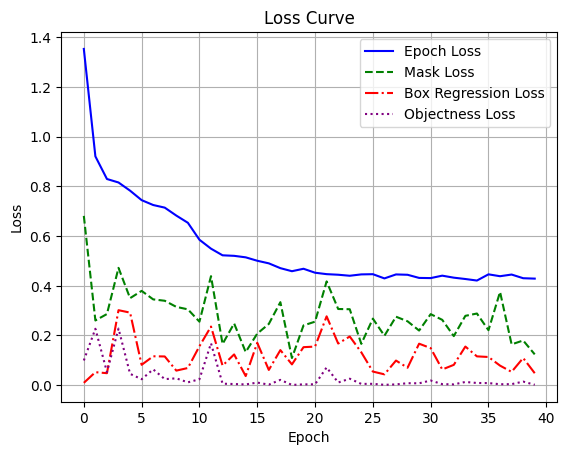

In [ ]:
from train_utils import draw_loss_plot
draw_loss_plot(epoch, model_dict)

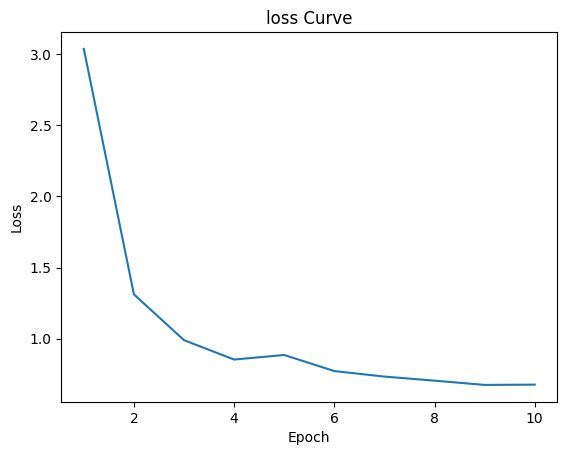

In [ ]:
from train_utils import plot_loss_curve
title = "loss Curve"
loss_path = None
plot_loss_curve(num_epochs,loss_path,epoch_loss,title)

# Evaluate

## coco_utils

### Convert val_dataset to coco format

In [ ]:
# from MyCoco import MyCocoDetection
from pycocotools import mask as coco_mask
def get_coco_api_from_dataset(dataset):
    # Check if the dataset is an instance of MyCocoDetection
    if isinstance(dataset, MyCocoDetection):
        return dataset.coco

    # Convert other types of datasets to COCO API format using your custom function
    return convert_to_coco_api(dataset)


def convert_to_coco_api(ds):
    coco_ds = COCO()
    # annotation IDs need to start at 1, not 0, see torchvision issue #1530
    ann_id = 1
    dataset = {"images": [], "categories": [], "annotations": []}
    categories = set()
    for img_idx in range(len(ds)):
      img, targets = ds[img_idx]
      if targets:
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict["id"] = image_id
        img_dict["height"] = img.shape[-2]
        img_dict["width"] = img.shape[-1]
        dataset["images"].append(img_dict)
        bboxes = targets["boxes"].clone()
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets["labels"].tolist()
        areas = targets["area"].tolist()
        iscrowd = targets["iscrowd"].tolist()
        if "masks" in targets:
            masks = targets["masks"]
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann["image_id"] = image_id
            ann["bbox"] = bboxes[i]
            ann["category_id"] = labels[i]
            categories.add(labels[i])
            ann["area"] = areas[i]
            ann["iscrowd"] = iscrowd[i]
            ann["id"] = ann_id
            if "masks" in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            dataset["annotations"].append(ann)
            ann_id += 1

    dataset["categories"] = [{"id": i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds

## coco_eval

### CocoEvaluator Class

In [ ]:
from __future__ import annotations
import copy
import io
from contextlib import redirect_stdout

import numpy as np
import pycocotools.mask as mask_util
import torch
import utils
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
import time
import numpy as np
import copy
import itertools
import os
from collections import defaultdict
import sys
PYTHON_VERSION = sys.version_info[0]
if PYTHON_VERSION == 2:
    from urllib import urlretrieve
elif PYTHON_VERSION == 3:
    from urllib.request import urlretrieve

class CocoEvaluator:
    def __init__(self, coco_gt, iou_types):
        if not isinstance(iou_types, (list, tuple)):
            raise TypeError(f"This constructor expects iou_types of type list or tuple, instead  got {type(iou_types)}")
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            annsImgIds = [res['image_id'] for res in results]
            with redirect_stdout(io.StringIO()):
                coco_dt = COCO.loadRes(self.coco_gt, results) if results else COCO()

            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def accumulate(self):
        print(self.coco_eval.values())
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print(f"IoU metric: {iou_type}")
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        if iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        raise ValueError(f"Unknown iou type {iou_type}")

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue
            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            coco_results.extend(
                [
                    {
                        "image_id": int(original_id),
                        "category_id": int(labels[k]),
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue
            masks = prediction["masks"].cpu().numpy()

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0] for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")
            coco_results.extend(
                [
                    {
                        "image_id": int(original_id),
                        "category_id": int(labels[k]),
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def evaluate(imgs):
    with redirect_stdout(io.StringIO()):
        imgs.evaluate()
    return imgs.params.imgIds, np.asarray(imgs.evalImgs).reshape(-1, len(imgs.params.areaRng), len(imgs.params.imgIds))


In [ ]:
import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
# from coco_eval import CocoEvaluator
# from CocoUtils import get_coco_api_from_dataset

@torch.inference_mode()
def coco_evaluate(model, data_loader, device):
    model.eval()
    header = "Test:"
    iou_types = ["bbox", "segm"]
    coco = get_coco_api_from_dataset(data_loader.dataset)

    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in data_loader:
        if not images:
          continue

        images = list(img.to(device) for img in images)

        outputs = model(images)

        outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

        res = {target["image_id"]: output for target, output in zip(targets, outputs)}

        coco_evaluator.update(res)

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    return coco_evaluator


### evaluate()

In [ ]:
# Load your trained weights
checkpoint_path = './save_weights/model_3_1.pth'
# model.load_state_dict(torch.load(checkpoint_path))
# Set the model in evaluation mode (important for batch normalization and dropout layers)
weights_path = os.path.join(drive_path,checkpoint_path)
# load train weights
os.path.exists(checkpoint_path), "{} file dose not exist.".format(checkpoint_path)
model_info = torch.load(weights_path)
weights_dict = model_info["model"] if "model" in model_info else model_info
model_dict = model_info["model_dict"]
epoch = model_info["epoch"]
model.load_state_dict(weights_dict)

<All keys matched successfully>

total_loss [114.10096830129623, 76.62757307291031, 79.33270579576492, 78.84163415431976, 76.55172461271286, 72.09251666069031, 70.7322233915329, 70.2322381734848, 70.04065811634064, 69.27922350168228, 68.55119109153748, 68.23517537117004, 69.03515726327896, 68.6968743801117, 68.08309942483902, 68.7024856209755, 69.26363956928253, 68.2358700633049, 67.89432245492935, 67.80300557613373]
epoch_loss [1.6070558915675526, 1.0792615925762015, 1.1173620534614779, 1.1104455514692924, 1.0781933044044065, 1.015387558601272, 0.9962284984722943, 0.9891864531476733, 0.9864881424836709, 0.9757637112912997, 0.9655097336836265, 0.9610588080446485, 0.9723261586377319, 0.9675616109874886, 0.9589168933075918, 0.9676406425489507, 0.9755442192856695, 0.9610685924409141, 0.9562580627454839, 0.9549719095230103]
loss_mask [0.5958316922187805, 0.4994659423828125, 0.43563586473464966, 0.45810699462890625, 0.39891064167022705, 0.5253482460975647, 0.3852420747280121, 0.5290541648864746, 0.3527012765407562, 0.42934

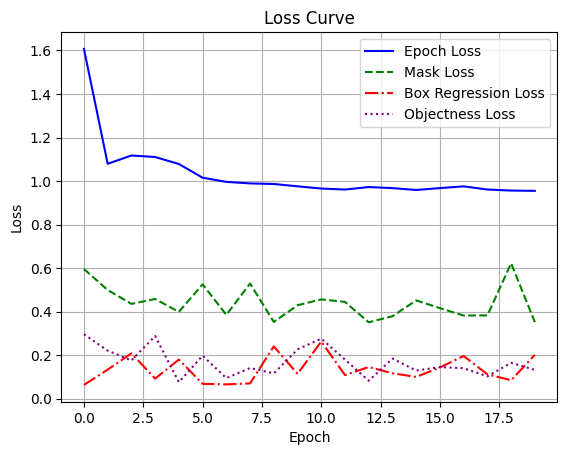

In [ ]:
from train_utils import draw_loss_plot
draw_loss_plot(epoch, model_dict)

In [ ]:
from saved_indices_model_5 import saved_indices
val_dataset = MyCocoDetection(root=image_root, annFile=ann_file, transform=get_transform(train=False))
print(saved_indices)
val_dataset = torch.utils.data.Subset(val_dataset, saved_indices)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=custom_collate_fn
)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
[487, 578, 349, 537, 463, 489, 581, 638, 584, 605, 387, 51, 95, 434, 43, 506, 132, 583, 589, 322, 449, 28, 337, 319, 152, 327, 510, 271, 633, 469, 254, 133, 36, 380, 448, 599, 571, 147, 292, 501, 621, 78, 22, 244, 32, 455, 156, 299, 355, 588, 318, 70, 482, 300, 611, 329, 544, 593, 413, 42, 89, 13, 233, 346, 125, 312, 360, 374, 249, 183, 600, 622, 315, 598, 415, 176, 111, 396, 570, 636, 171, 91, 110, 264, 615, 459, 347, 301, 401, 471, 560, 98, 30, 624, 9, 35, 507, 549, 378, 577]


In [ ]:
torch.cuda.empty_cache()

In [ ]:
coco_evaluate(model,val_dataloader,config.device)

creating index...
index created!
dict_values([<pycocotools.cocoeval.COCOeval object at 0x7ad5b0e45ed0>, <pycocotools.cocoeval.COCOeval object at 0x7ad4d2894130>])
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.

# Inference

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import os
from PIL import Image
import config
import matplotlib.pyplot as plt
import numpy as np
import json
from draw_box_utils import draw_objs

In [ ]:
from saved_indices_model_3 import saved_indices
print(saved_indices)

[584, 655, 492, 314, 554, 503, 251, 448, 163, 32, 473, 55, 502, 419, 283, 469, 61, 370, 230, 84, 420, 382, 342, 574, 3, 12, 527, 640, 56, 352, 133, 217, 644, 69, 74, 598, 401, 7, 645, 13, 567, 518, 127, 271, 259, 491, 373, 298, 609, 365, 519, 53, 81, 582, 137, 405, 280, 52, 1, 159, 139, 558, 45, 578, 174, 386, 59, 98, 2, 97, 254, 540, 240, 379, 286, 318, 222, 498, 608, 522, 393, 114, 476, 62, 425, 165, 272, 562, 661, 196, 172, 572, 18, 11, 134, 407, 487, 183, 215, 555]


In [ ]:
from PIL import Image
# load image
image_file = '655'
img_path = os.path.join(drive_path,f'images/{image_file}.jpg')
os.path.exists(img_path), f"{img_path} does not exits."
original_img = Image.open(img_path).convert('RGB')

# from pil image to tensor, do not normalize image
# data_transform = transforms.Compose([transforms.ToTensor()])
data_transform = get_transform(train=False)
img = data_transform(original_img)
print(img.shape)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

torch.Size([3, 2160, 3840])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [ ]:
# Load the list of COCO class labels
label_json_path = os.path.join(drive_path,"label_json_path.json")
os.path.exists(label_json_path), "json file {} dose not exist.".format(label_json_path)
with open(label_json_path, 'r') as json_file:
    coco_labels = json.load(json_file)
print(coco_labels)

{'1': 'Spirobranchus triqueter', '2': 'Barnacle', '3': 'Obelia longissima', '4': 'Mytilus edulis', '5': 'Diadumene cincta', '6': 'Botryllus schlosseri', '7': 'Halichondria spp.'}


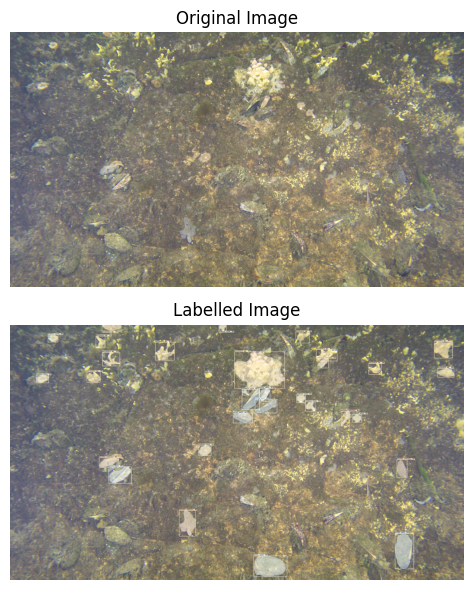

In [ ]:
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

with torch.no_grad():
    model.eval()
    img_height, img_width = img.shape[-2:]
    init_img = torch.zeros((1, 3, img_height, img_width), device=config.device)
    model(init_img)
    predictions = model(img.to(config.device))[0]
    # print(predictions[0])
    predict_boxes = predictions["boxes"].to("cpu").numpy()
    predict_classes = predictions["labels"].to("cpu").numpy()
    predict_scores = predictions["scores"].to("cpu").numpy()
    predict_mask = predictions["masks"].to("cpu").numpy()
    predict_mask = np.squeeze(predict_mask, axis=1)  # [batch, 1, h, w] -> [batch, h, w]

    if len(predict_boxes) == 0:
        print("no object")
    else:
      analyzeImage(predict_boxes,predict_classes,coco_labels,image_file)
      ''' print("predict_boxes:",predict_boxes)
      print("predict_classes",predict_classes)
      print("predict_scores",predict_scores)
      print("predict_mask",predict_mask) '''

    plot_img = draw_objs(original_img,
                boxes=predict_boxes,classes=predict_classes,
                scores=predict_scores,
                masks=predict_mask,
                category_index=coco_labels,
                line_thickness=3,
                font='arial.ttf',
                font_size=40)

    axes[1].imshow(plot_img)
    axes[1].set_title("Labelled Image")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    # save results
    # plot_img.save("test_result.jpg")


In [ ]:
import pandas as pd
def calculate_area(box):
    # Calculate the area of a bounding box
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    area = width * height
    return area
def analyzeImage(predict_boxes,predict_classes,coco_labels,image_file):
  # Create a DataFrame to store the detection results
  classes = [coco_labels[str(i)] for i in predict_classes]
  areas = [calculate_area(box) for box in predict_boxes]

  data = {'Class': classes, 'Area': areas}
  df = pd.DataFrame(data)
  groups = df.groupby(df.Class)
  reset_group_data = [group_data.reset_index(drop=True) for name, group_data in groups]
  merged_data = pd.concat(reset_group_data)

  # Save the merged data to a file
  merged_data.to_csv(f'Inference/{image_file}.csv', index=True)

